In [ ]:
pip install tensorflow

In [ ]:
import pandas as pd
import tensorflow as tf
import keras
from pprint import pprint
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
links= pd.read_csv('links.csv')
movies= pd.read_csv('movies.csv')
ratings= pd.read_csv('ratings.csv')
tags= pd.read_csv('tags.csv')

In [ ]:
links.shape

(9742, 3)

In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
links.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [ ]:
links.dropna(inplace=True)

In [ ]:
links.shape

(9734, 3)

In [ ]:
movies.shape

(9742, 3)

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [ ]:
ratings.shape

(100836, 4)

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [ ]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [ ]:
tags.shape

(3683, 4)

In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [ ]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

# we require only two files ratings and movies

In [ ]:
# we require only two files ratings and movies
merged_dataset = pd.merge(ratings, movies, how='inner', on='movieId')
merged_dataset.drop(columns=['timestamp', 'genres'], inplace=True)
merged_dataset.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [ ]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


# It should be noted that there are 11 classes of rating

In [ ]:
refined_dataset['rating'].unique()

array([4.  , 5.  , 3.  , 2.  , 1.  , 3.5 , 4.5 , 2.5 , 0.5 , 1.5 , 2.25])

## Encoding users and movieID so that the DNNs encounter no missing values

In [ ]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].values)
n_users = refined_dataset['user'].nunique()

In [ ]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['movie'].nunique()

In [ ]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
print('unique users, unique movies, min_rating, max_rating')
n_users, n_movies, min_rating, max_rating

unique users, unique movies, min_rating, max_rating


(610, 9719, 0.5, 5.0)

In [ ]:
refined_dataset.head()

,userId,title,rating,user,movie
0,1,"13th Warrior, The (1999)",4.0,0,48
1,1,20 Dates (1998),4.0,0,66
2,1,"Abyss, The (1989)",4.0,0,202
3,1,"Adventures of Robin Hood, The (1938)",5.0,0,245
4,1,Alice in Wonderland (1951),5.0,0,325


# Splitting data into train and test

In [ ]:
# movie and user are the features for training wich will be converted to embeddings
X = refined_dataset[['user', 'movie']].values

In [ ]:
y = refined_dataset['rating'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90748, 2), (10084, 2), (90748,), (10084,))

# Dimension of the embeddings

In [ ]:
n_factors = 150

In [ ]:
# some reshaping needs to be done so that it can be a suitable input for keras
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
X_train.shape, X_train_array[0].shape

((90748, 2), (90748,))

# Constructing layers of Softmax DNN

In [ ]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with softmax activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(11)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Define the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)

## compile the model
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 150)               91500     ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 1, 150)               1457850   ['input_4[0][0]']             
                                                                                            

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=100, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/100
709/709 [==============================] - 13s 17ms/step - loss: 1.7650 - accuracy: 0.2183 - val_loss: 1.5358 - val_accuracy: 0.2647 - lr: 0.0100
Epoch 2/100
709/709 [==============================] - 12s 17ms/step - loss: 1.5105 - accuracy: 0.2497 - val_loss: 1.4873 - val_accuracy: 0.2710 - lr: 0.0100
Epoch 3/100
709/709 [==============================] - 12s 17ms/step - loss: 1.4858 - accuracy: 0.2550 - val_loss: 1.4749 - val_accuracy: 0.2801 - lr: 0.0100
Epoch 4/100
709/709 [==============================] - 12s 17ms/step - loss: 1.4758 - accuracy: 0.2568 - val_loss: 1.4682 - val_accuracy: 0.2758 - lr: 0.0100
Epoch 5/100
709/709 [==============================] - 12s 17ms/step - loss: 1.4691 - accuracy: 0.2608 - val_loss: 1.4630 - val_accuracy: 0.2798 - lr: 0.0100
Epoch 6/100
709/709 [==============================] - 12s 17ms/step - loss: 1.4633 - accuracy: 0.2612 - val_loss: 1.4576 - val_accuracy: 0.2823 - lr: 0.0100
Epoch 7/100
709/709 [==============================]

# Plotting train and test accuracies for each epoch

In [ ]:
import pickle

filename = 'softmax_recommender.pkl'
pickle.dump(model, open(filename, 'wb'))

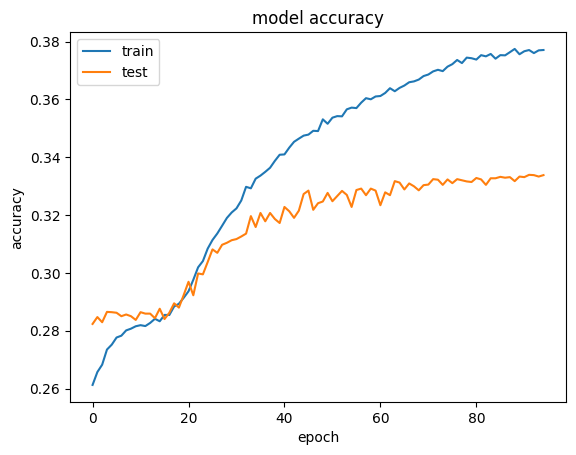

In [ ]:
plt.plot(history.history["accuracy"][5:])
plt.plot(history.history["val_accuracy"][5:])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Plotting train and test loss for each epoch

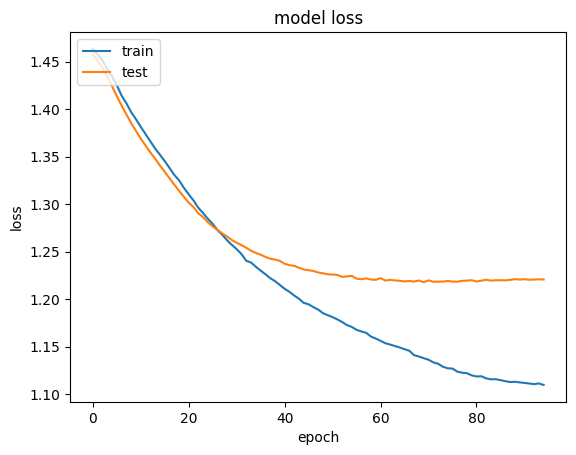

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Getting y_pred or predicted ratings

In [ ]:
predicted_ratings = model.predict(X_test_array)

316/316 [==============================] - 1s 2ms/step


In [ ]:
predicted_ratings.shape

(10084, 11)

In [ ]:
predicted_ratings

array([[1.3311481e-04, 2.8605884e-04, 5.1724520e-03, ..., 2.0641107e-06,
        1.3270197e-06, 1.8040927e-06],
       [4.7729544e-02, 1.2593170e-01, 2.7951682e-01, ..., 1.1871808e-03,
        9.2383072e-04, 8.3099783e-04],
       [1.0531247e-03, 2.7081554e-03, 4.6144355e-02, ..., 7.9986712e-06,
        4.0292789e-06, 4.5451225e-06],
       ...,
       [2.2233628e-02, 1.3441442e-01, 3.8993749e-01, ..., 1.7355272e-04,
        1.2200476e-04, 1.2526603e-04],
       [1.1347390e-03, 4.7676647e-03, 2.5123572e-02, ..., 3.0376154e-05,
        4.4242759e-05, 3.0539515e-05],
       [1.5496698e-03, 4.9621905e-03, 4.1223168e-02, ..., 3.2849446e-05,
        3.5481273e-05, 2.8211463e-05]], dtype=float32)

In [ ]:
max_indices = np.argmax(predicted_ratings, axis=1)

In [ ]:
max_indices.shape

(10084,)

In [ ]:
# Create a numpy array
original_array = max_indices

# Define a mapping dictionary
value_mapping = {1:0.5, 2:1., 3:1.5, 4:2., 5:2.25, 6:2.5, 7:3., 8:3.5, 9:4., 10:4.5, 11:5.}

# Define a function to apply the mapping
def map_function(value):
    return value_mapping.get(value, value)

# Vectorize the mapping function
mapped_array = np.vectorize(map_function)(original_array)

print("Original Array:", original_array)
print("Mapped Array:", mapped_array)

Original Array: [4 3 3 ... 3 5 4]
Mapped Array: [2.   1.5  1.5  ... 1.5  2.25 2.  ]


In [ ]:
X_test_array

[array([185, 364, 569, ...,  56,  89, 552]),
 array([3147, 6205, 5029, ..., 9045,  550, 5475])]

In [ ]:
y_test

array([5. , 4. , 3.5, ..., 2. , 5. , 5. ], dtype=float32)

In [ ]:
columns = ['user','movies']
reconstructed_testdata = pd.DataFrame(X_test_array)
reconstructed_testdata = reconstructed_testdata.T
reconstructed_testdata. columns = columns
reconstructed_testdata['actual_ratings'] = y_test
reconstructed_testdata['predicted_ratings'] = mapped_array

In [ ]:
reconstructed_testdata

,user,movies,actual_ratings,predicted_ratings
0,185,3147,5.0,2.00
1,364,6205,4.0,1.50
2,569,5029,3.5,1.50
3,18,4510,3.0,2.00
4,609,3008,4.5,2.00
...,...,...,...,...
10079,67,2770,2.5,1.50
10080,201,5181,3.0,2.00
10081,56,9045,2.0,1.50
10082,89,550,5.0,2.25


In [ ]:
user_actual_predicted_test = reconstructed_testdata.copy().groupby('user', as_index=False)['movies'].agg({'actual': (lambda x: list(set(x)))})

In [ ]:
user_actual_predicted_test

,user,actual
0,0,"[4867, 4882, 1048, 6808, 4766, 2464, 3489, 361..."
1,1,"[4396, 4373]"
2,2,"[490, 6347, 76, 3938]"
3,3,"[9348, 9485, 5780, 3102, 7326, 7711, 7457, 34,..."
4,4,"[7555, 836, 6632, 713, 6923, 7054, 7805]"
...,...,...
595,605,"[2048, 3081, 522, 7696, 5136, 8723, 1555, 3610..."
596,606,"[6402, 8003, 836, 9542, 3499, 2059, 7673, 9039..."
597,607,"[6667, 5133, 17, 2067, 3098, 5157, 549, 1070, ..."
598,608,"[2619, 2770, 8675, 3279]"


# Lets get a list of actual and predicted/recommended movies for each user

In [ ]:
def get_k_users_predictions(user_id, k, reconstructed_testdata):
    return list(reconstructed_testdata[reconstructed_testdata['user']==user_id][['movies','predicted_ratings']].sort_values(by='predicted_ratings', ascending=False).head(k)['movies'])


In [ ]:
cf_recs = []
for user in user_actual_predicted_test.index:
    cf_predictions = get_k_users_predictions(user, 5, reconstructed_testdata)
    cf_recs.append(cf_predictions)

In [ ]:
user_actual_predicted_test['predictions'] = cf_recs
user_actual_predicted_test.head()

,user,actual,predictions
0,0,"[4867, 4882, 1048, 6808, 4766, 2464, 3489, 361...","[9340, 4867, 2885, 3570, 6808]"
1,1,"[4396, 4373]","[4396, 4373]"
2,2,"[490, 6347, 76, 3938]","[490, 3938, 76, 6347]"
3,3,"[9348, 9485, 5780, 3102, 7326, 7711, 7457, 34,...","[5780, 7457, 34, 2940, 6398]"
4,4,"[7555, 836, 6632, 713, 6923, 7054, 7805]","[713, 836, 7805, 7555, 6632]"


# Get popular recommendations list

In [ ]:
popularity_recs = ratings.movieId.value_counts().head(5).index.tolist()
popularity_recs

[356, 318, 296, 593, 2571]

In [ ]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

pop_recs = []
for user in user_actual_predicted_test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)

user_actual_predicted_test['pop_predictions'] = pop_recs
user_actual_predicted_test.head()

,user,actual,predictions,pop_predictions
0,0,"[4867, 4882, 1048, 6808, 4766, 2464, 3489, 361...","[9340, 4867, 2885, 3570, 6808]","[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."
1,1,"[4396, 4373]","[4396, 4373]","[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."
2,2,"[490, 6347, 76, 3938]","[490, 3938, 76, 6347]","[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."
3,3,"[9348, 9485, 5780, 3102, 7326, 7711, 7457, 34,...","[5780, 7457, 34, 2940, 6398]","[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."
4,4,"[7555, 836, 6632, 713, 6923, 7054, 7805]","[713, 836, 7805, 7555, 6632]","[356, 318, 296, 593, 2571, 260, 480, 110, 589,..."


In [ ]:
actual = user_actual_predicted_test.actual.values.tolist()
softmax_predictions = user_actual_predicted_test.predictions.values.tolist()
pop_predictions = user_actual_predicted_test.pop_predictions.values.tolist()

# Lets plot Mean Average Recall @ K for both popularity recommender and

In [ ]:
pip install recmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does

In [ ]:
import recmetrics

In [ ]:
pop_mark = []
for K in np.arange(1, 6):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0, 0.0, 3.135753135753135e-05, 4.959869879224717e-05, 4.959869879224717e-05]

In [ ]:
softmax_mark = []
for K in np.arange(1, 6):
    softmax_mark.extend([recmetrics.mark(actual, softmax_predictions, k=K)])
softmax_mark

[0.07370048742580375,
 0.1294053956002076,
 0.16926950406375532,
 0.1985960262479311,
 0.219060905432306]

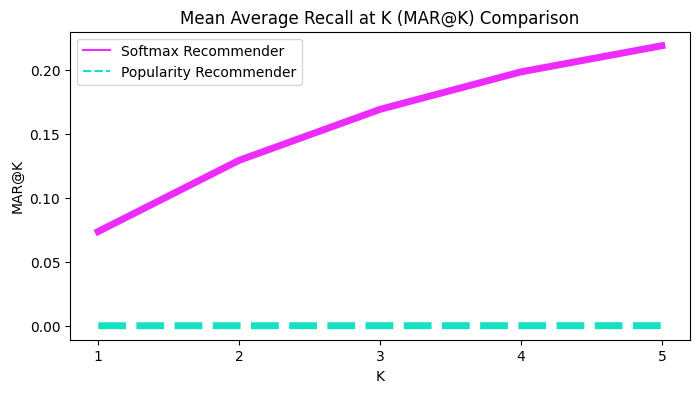

In [ ]:
mark_scores = [softmax_mark, pop_mark]
index = range(1,5+1)
names = ['Softmax Recommender','Popularity Recommender']

fig = plt.figure(figsize=(8, 4))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [ ]:
catalog = ratings.movieId.unique().tolist()
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
sf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)

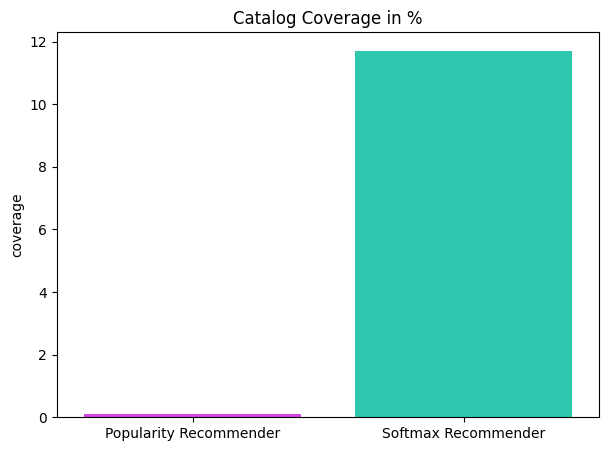

In [ ]:
# plot of prediction coverage
coverage_scores = [pop_coverage, sf_coverage]
model_names = ['Popularity Recommender', 'Softmax Recommender']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Getting movies for a single user on sunseen movies

In [ ]:
import pickle

# loading pre-trained and saved pikle model
filename = 'softmax_recommender.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
  print("")

  print("---------------------------------------------------------------------------------")

  encoded_user_id = user_enc.transform([user_id])

  # extracting seen and unseen movies
  seen_movies = list(refined_dataset[refined_dataset['userId'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  # predict the ratings for unseen movies
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  index_pd = pd.DataFrame(predicted_ratings,columns=['predicted_rating'], index=unseen_movies)
  # sort the ratings and select top n movies
  sorted_index = index_pd.sort_values(by='predicted_rating',ascending=False).index
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

In [ ]:
print('Number of unique users: ', len(refined_dataset['userId'].unique()))
print('select a user id below: ', len(refined_dataset['userId'].unique()))

print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id, model, n_movies)

Number of unique users:  610
select a user id below:  610
Enter user id
2
Enter number of movies to be recommended:
5

Movie seen by the User:
['Collateral (2004)',
 'Dark Knight Rises, The (2012)',
 'Dark Knight, The (2008)',
 'Departed, The (2006)',
 'Django Unchained (2012)',
 'Ex Machina (2015)',
 'Exit Through the Gift Shop (2010)',
 'Girl with the Dragon Tattoo, The (2011)',
 'Gladiator (2000)',
 'Good Will Hunting (1997)',
 'Inception (2010)',
 'Inglourious Basterds (2009)',
 'Inside Job (2010)',
 'Interstellar (2014)',
 'Kill Bill: Vol. 1 (2003)',
 'Louis C.K.: Hilarious (2010)',
 'Mad Max: Fury Road (2015)',
 'Shawshank Redemption, The (1994)',
 'Shutter Island (2010)',
 'Step Brothers (2008)',
 'Talladega Nights: The Ballad of Ricky Bobby (2006)',
 'The Drop (2014)',
 'The Jinx: The Life and Deaths of Robert Durst (2015)',
 'Tommy Boy (1995)',
 'Town, The (2010)',
 'Warrior (2011)',
 'Whiplash (2014)',
 'Wolf of Wall Street, The (2013)',
 'Zombieland (2009)']

---------------